## Simulation of level density analysis

Simulate a spectrum (with parameters to mimic $^{154}$Sm).
1. Level spacing according to Wigner distribution.
2. Level intensity from Porter-Thomas distribution.
3. Experimental resolution of 40 keV FWHM.
4. Simulation constructed on expanded grid and then compressed into bins of 5 keV width.
5. Noise is added after the spectrum is constructed, to simulate the effect of counting statistics.
6. Only a constant spectrum.

### Results.

1. Noise correction is applied.
2. Provided $\sigma$ is kept constant, good results are obtained for both narrow smoothing and with no narrow smoothing.
3. Even with $\sigma$ a fit parameter, results are good.
4. With $\sigma$ a fit parameter and no noise correction, results are worse.

### Conclusions.

Noise corrections are important.

In [1]:
import numpy as np
import numpy.random as rnd
import spectrumtools as spt
import matplotlib.pyplot as plt
import leveldensities as ldn
import lmfit
import simlibx as sim
import spectrumtools as spt

plt.rc('font',size=16)

In [2]:
Noisy=True
#Noisy=False
# do we use narrow smoothing as well as wide?
NarrowSmooth=True
NarrowSmooth=False

ZapCorrection=False


def simulate_spectrum(Elo,Ehi,binwidth,lineshape, sigma, factor=10.0, noisy=False):
    """
    from simlib; modified
    generate a simulted spectrum in Nspect channels
    with a mean of Npk peaks.
    Each line has a shape and width determined by linehape and sigma (in channels)
    """
    Nspect=int((Ehi-Elo)/binwidth+0.5)
    w0=binwidth/10.0
    sig=sigma/w0
    g=np.zeros(Nspect*10)
    D=0.0001054  # mean level spacing
    #print('** D=',D, '    rho=',1.0/D)
    e = Elo            # peak energy
    spectrum=[]
    N=0
    while e < Ehi:
        N+=1
        x=D*sim.randomWigner()          # random level space
        y=sim.randomPT()                     # random strength
        e+=x                             # energy of level
        spectrum.append((e,y))
        ne=int((e-Elo)/w0+0.5)                    # force energy to nearest channel
        if ne<Nspect*10.0: g[ne]+=y                # into spectrum
    # convolute with line shape
    G=sim.convolute(g, lineshape, sig)#*1000.0
    #G=sim.convolute(G,lineshape,sig*0.8)
    G=G.reshape((Nspect,10))
    G=np.sum(G,axis=1)
    g=g.reshape((Nspect,10))
    g=np.sum(g,axis=1)
    #factor=10.0
    #factor=1.0
    Gshape=np.linspace(1.0,10.0,len(G))
    if noisy:
        meang=np.mean(G)
        #G=G*Gshape
        sigG=np.sqrt(meang)
        noiseG=rnd.randn(len(G))*sigG
        #print("noisy")
        #G=G+noiseG/factor
    #print(N,sig,w0,binwidth)
    return G, g, spectrum, noiseG  # improve this ?


In [3]:
# The following parameters should probably remain fixed

# lineshape for convolutions
lineshape=sim.gauss


# set smoothing parameters in channels
smoothwide=3.5 # from 3.5
smoothnarrow=0.39*2.35

alpha=2.0+0.273            # default for N=1

esig,sig=0.0,33.0 # fwhm of experimental resolution in keV  <<<<<<<<<<<<<<<<<<<<<<<<<
print("Assumed fwhm of resolution fn is %5.1f keV"%(sig))
print(":Smooth factors: wide %5.1f; narrow %5.2f"%(smoothwide,smoothnarrow))
# convert to sdev of gaussian in MeV
sig/=1000.0   # sig in MeV
sig/=2.3      # FWHM to stdev
#print("sig",sig, sig*2.3)
# calculate smoothing widths
sigsmn=smoothnarrow*sig       # < sig   . should be 0.5*FWHM ?
sigsm=smoothwide*sig       # in MeV
sigexpt=sig
sigsm0=sigsm
sigx=sigsm*2


Assumed fwhm of resolution fn is  33.0 keV
:Smooth factors: wide   3.5; narrow  0.92


In [4]:
D=0.0001054
de=0.005
# at 5 keV / channel
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800

ROIlo=ROIlo+50
ROIhi=ROIhi+50

rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV

#rnd.seed( 75096521 )

de=0.005
rawG,hraw,rawspectrum,rawnoiseG=simulate_spectrum(10.0,20.0,de,sim.gauss,
                                         sig,
                                         factor=10.0,noisy=Noisy)
X=np.arange(0.0,2000.0,1.0)*0.005+10.0
e=X
Nspect=len(rawG)
Nlo=ROIlo
Nhi=ROIhi
Exlo,Exhi=(e[ROIlo],e[ROIhi])
print(Exlo,Exhi)

print("ROI for analysis",Nlo, Nhi, ROIlo, ROIhi)


11.25 19.25
ROI for analysis 250 1850 250 1850


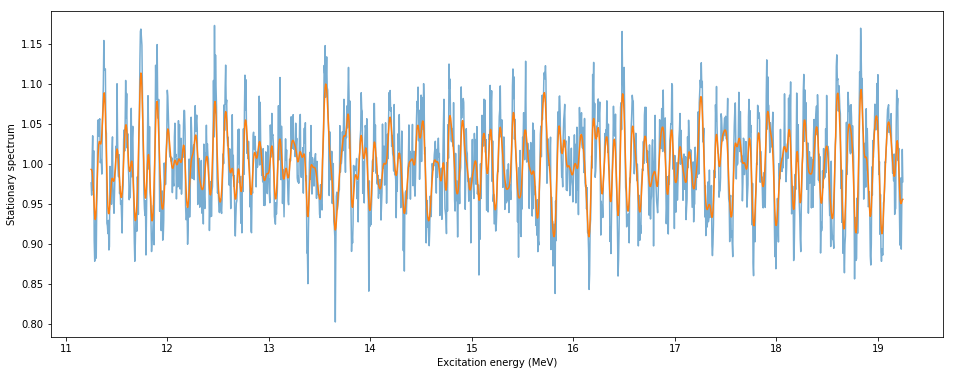

In [5]:
noisefactor=5.0
G=rawG+rawnoiseG/noisefactor
S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
globalenergy = S.energy

if NarrowSmooth:
    iAC=0             # first point in autocorrelation fit
    firstoffset=0.0       # energy offset of first point
else:                 # if no narrow smooth, ignore noise in first channel
    iAC=1
    firstoffset=de

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

plt.figure(figsize=(16,6))
plt.plot(Eratio, ratioraw, alpha=0.6)
plt.plot(Eratio, rationar)
#plt.plot(Eratio,S.data[ROIlo:ROIhi])
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Stationary spectrum")
plt.show()

In [6]:
def fitforlm( params, e, data, unc=None ):
    """
    fit function for least sq fit using lmfit
    """
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    #sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    if unc is None:
        unc=np.ones(len(data))*p['initD']*0.2
    return (model-data)/unc

def model(params, e):
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    return model

In [7]:
ifig=1
Varysign=True
print("NarrowSmooth ",NarrowSmooth)
print("ZapCorrection", ZapCorrection)
print("Varysign     ", Varysign)
noisefactors=[10.0,5.0,3.0,2.0,1.5,1.2,1.0]
computedrho=[] # computed from AC[0]-noise, expt sign


NarrowSmooth  False
ZapCorrection False
Varysign      True


800 1200
initialD 0.000057 estimated from AC 0.002567
noisecorrection 0.0003351544658262043
[[Variables]]
    D:       8.5246e-05 +/- 7.21e-07 (0.85%) (init= 5.74387e-05)
    sign:    0.01325471 +/- 7.35e-05 (0.55%) (init= 0.01434783)
    sigw:    0.05222688 (fixed)
    sigx:    0.1004348 (fixed)
    initD:   0.0002297548 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(D, sign)                   =  0.853 
9974.252277667854 0.00010025814187986597 0.0022317696131047677
0.005 0.013254717166152785 0.05222687529266459 2.273
At 0 0.0022317696131047677 0.0023011499627854483 25.420186752636102
Computed rho 9987.131154545914
800 1200
initialD 0.000070 estimated from AC 0.003112
noisecorrection 0.000914266696093546
[[Variables]]
    D:       8.4927e-05 +/- 8.55e-07 (1.01%) (init= 6.962879e-05)
    sign:    0.01341882 +/- 8.79e-05 (0.66%) (init= 0.01434783)
    sigw:    0.05222688 (fixed)
    sigx:    0.1004348 (fixed)
    initD:   0.0002785152 (fixed)
[[Correlations]] (unre

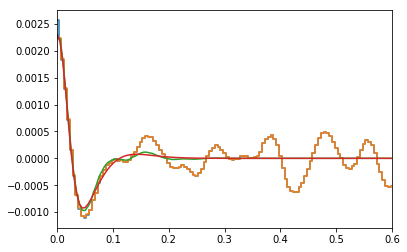

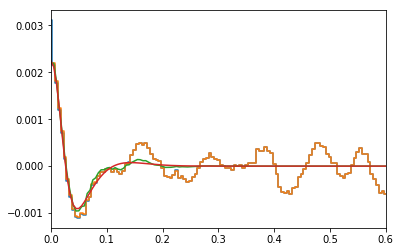

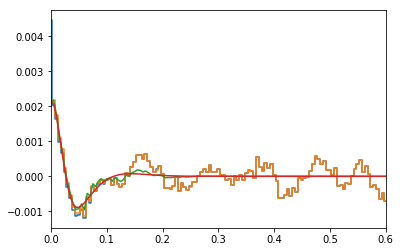

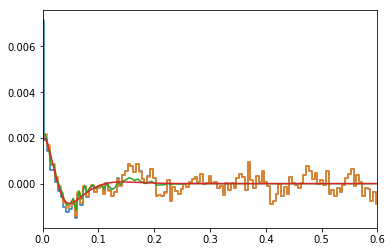

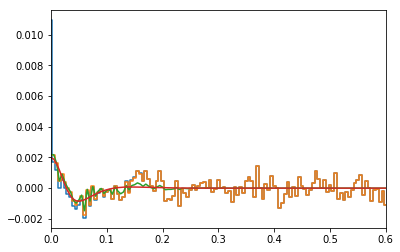

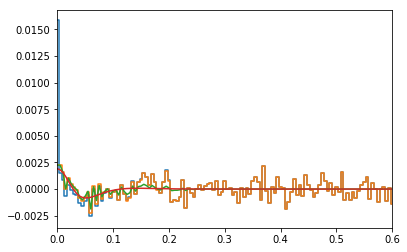

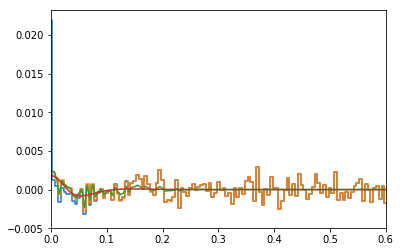

In [20]:
rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800

ROIlo=ROIlo+50
ROIhi=ROIhi+50

#rnd.seed( 75096521 )

#rawG,hraw,rawspectrum,rawnoiseG=simulate_spectrum(10.0,20.0,0.005,sim.gauss,
#                                         sig,
#                                         factor=10.0,noisy=Noisy)
computedrho=[] # computed from AC[0]-noise, expt sign
for noisefactor in [10.0,5.0,3.0,2.0,1.5,1.2,1.0]:
#for noisefactor in [1.0]:
    G=rawG+rawnoiseG/noisefactor
    S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
    globalenergy = S.energy

    S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

    Eratio=S.Eratio
    ratioraw=S.ratioraw
    rationar=S.rationar
    """
    plt.figure(figsize=(16,6))
    plt.plot(Eratio, ratioraw, alpha=0.6)
    plt.plot(Eratio, rationar)
    #plt.plot(Eratio,S.data[ROIlo:ROIhi])
    plt.xlabel("Excitation energy (MeV)")
    plt.ylabel("Stationary spectrum")
    plt.show()
    """
    bins=spt.ACBinner(S,NAC=4,Nslides=2)
    #print("Computed bin limits:\n",bins.get_bins())
    binlist=bins.get_bins()
    index=4
    l,h=binlist[index]
    print(l,h)
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    if NarrowSmooth:
        data=bin.acnar
    else:
        data=bin.acraw
    # calculate alpha from M1 fraction assuming N1=N2
    # first get mean m1 fraction

    # increase sig to account for convolution of g
    sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
    sign=sig
    if NarrowSmooth:
        sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
        sigaim=sig
    ys=sigw/sign
    ys=sigw/sign
    alpha=2.273
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    print("initialD %8.6f estimated from AC %8.6f"%(initialD,data[0]))
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sign,min=0.0, vary=True)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    params.add('initD',value=initialD*4,vary=False)
    noise=bin.get_noise_correction2(sigsmn, sigsm, NarrowSmooth)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
    print("noisecorrection",noise[0])
    #ACfx=data*np.exp(-energy**2/(2.0*sigx**2))
    #initial=1.0
    #popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
    #sig=popt[1]
    #popt[0]*=initialD
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx))
                           #fcn_kws={'unc'=uncert})
    result=minner.minimize()
    m=model(result.params, energy)
    lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    Ntypes = 1 
    signf=p['sign']
    sigwf=p['sigw']
    D=ACfx[0]/spt.ACtheory(de,signf,sigwf,alpha,1.0)*Ntypes
    D=ACfx[0]/spt.ACtheory(de,sign,sigw,alpha,1.0)*Ntypes
    #D=p["D"]*Ntypes
    rho=1.0/D
    print(rho, D, ACfx[0])
    
    plt.figure()
    plt.plot(energy, data, drawstyle='steps-mid')
    plt.plot(energy, data-noise, drawstyle='steps-mid')
    plt.plot(energy,ACfx)
    plt.plot(energy, m)
    plt.xlim(0.0,energy[-1]/4)
    plt.xlim(0.0,0.6)
    """ 
    plt.plot(bin.spectrumraw)
    """
    print(de,p['sign'],sigw,alpha )
    print("At 0", ACfx[0], m[0], spt.ACtheory(de,p['sign'],sigw,alpha,1.0))
    print("Computed rho",1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))
    computedrho.append(1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))

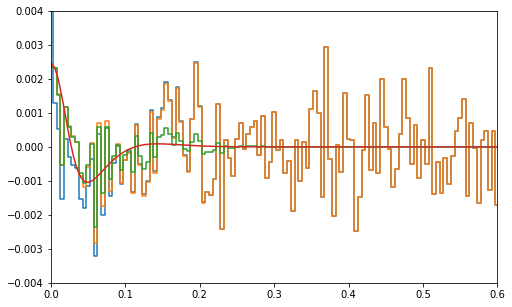

In [22]:
# replot of last
plt.figure(figsize=(8,5))
plt.plot(energy, data, drawstyle='steps-mid')
plt.plot(energy, data-noise, drawstyle='steps-mid')
plt.plot(energy,ACfx, drawstyle='steps-mid')
m=spt.ACtheory(energy, sign, sigw, alpha, D)
plt.plot(energy, m)
plt.xlim(0.0,energy[-1]/4)
plt.xlim(0.0,0.6)
plt.ylim(-0.004,0.004)
plt.show()

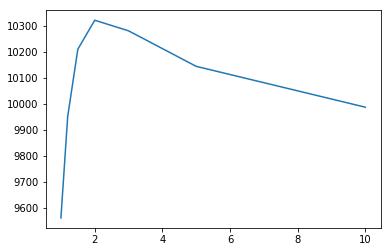

In [23]:
plt.plot(noisefactors,computedrho)

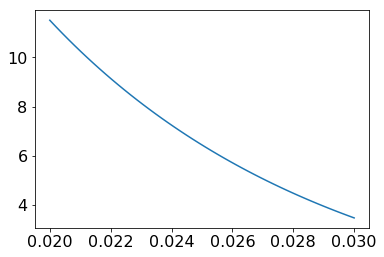

In [30]:
sn=np.linspace(0.020,0.030,50)
hf=spt.ACtheory(de,sn,sigw,alpha,1.0)
plt.plot(sn,hf)

0 400
initialD 0.000027 estimated from AC 0.001225
noisecorrection 0.00011845557616270053
[[Variables]]
    D:       7.6311e-05 +/- 1.05e-06 (1.37%) (init= 2.740064e-05)
    sign:    0.01946219 (fixed)
    sigw:    0.05222688 (fixed)
    sigx:    0.1004348 (fixed)
    initD:   0.0001096026 (fixed)
11072.74886291732
0.005 0.019462191451054652 0.05222687529266459 2.273
At 0 0.0011060734798039357 0.0009679202717394627 12.247273865802033
Computed rho 11072.74886291732
200 600
initialD 0.000023 estimated from AC 0.001014
noisecorrection 0.00011764872858485022
[[Variables]]
    D:       6.0366e-05 +/- 9.14e-07 (1.51%) (init= 2.268984e-05)
    sign:    0.01946219 (fixed)
    sigw:    0.05222688 (fixed)
    sigx:    0.1004348 (fixed)
    initD:   9.075936e-05 (fixed)
13663.408379984558
0.005 0.019462191451054652 0.05222687529266459 2.273
At 0 0.0008963556914351611 0.0007656705097647872 12.247273865802033
Computed rho 13663.408379984558
400 800
initialD 0.000026 estimated from AC 0.001174
noise

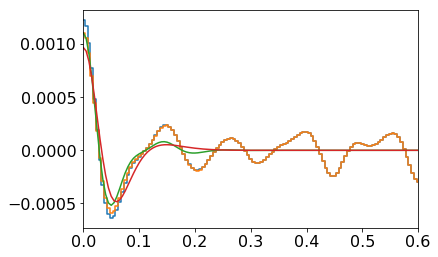

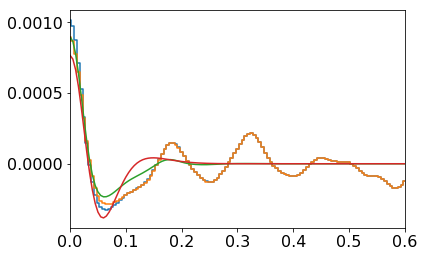

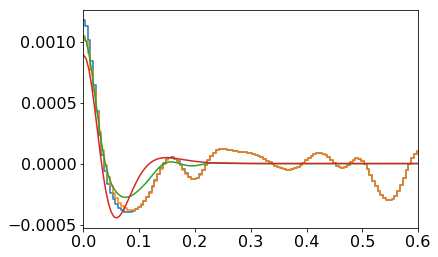

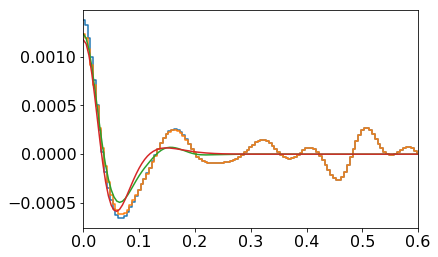

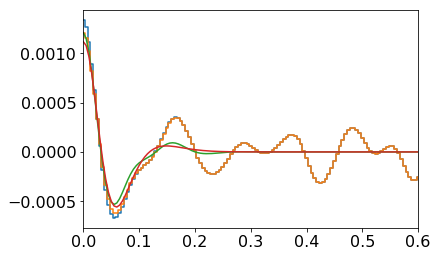

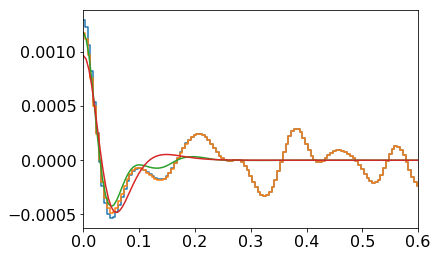

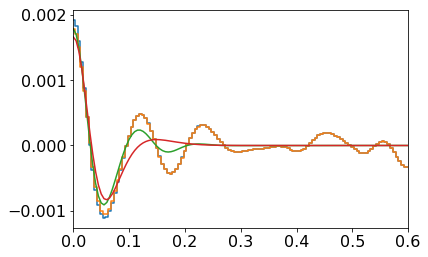

In [33]:
computedrho=[] # computed from AC[0]-noise, expt sign

noisefactor=3.0
G=rawG+rawnoiseG/noisefactor
S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
globalenergy = S.energy

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

bins=spt.ACBinner(S,NAC=4,Nslides=2)
#print("Computed bin limits:\n",bins.get_bins())
binlist=bins.get_bins()

for b in bins.get_bins():
    l,h=b
    print(l,h)
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    data=bin.acnar
    # calculate alpha from M1 fraction assuming N1=N2
    # first get mean m1 fraction

    # increase sig to account for convolution of g
    sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
    sign=sig
    if NarrowSmooth:
        sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
        sigaim=sig
    ys=sigw/sign
    ys=sigw/sign
    alpha=2.273
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    print("initialD %8.6f estimated from AC %8.6f"%(initialD,data[0]))
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sign,min=0.0, vary=False)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    params.add('initD',value=initialD*4,vary=False)
    noise=bin.get_noise_correction(sigsmn, sigsm)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
    print("noisecorrection",noise[0])
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx))
                           #fcn_kws={'unc'=uncert})
    result=minner.minimize()
    m=model(result.params, energy)
    lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    Ntypes = 1 
    signf=p['sign']
    sigwf=p['sigw']
    D=ACfx[0]/spt.ACtheory(de,signf,sigwf,alpha,1.0)*Ntypes
    #D=p["D"]*Ntypes
    rho=1.0/D
    print(rho)
    
    plt.figure()
    plt.plot(energy, data, drawstyle='steps-mid')
    plt.plot(energy, data-noise, drawstyle='steps-mid')
    plt.plot(energy,ACfx)
    plt.plot(energy, m)
    plt.xlim(0.0,energy[-1]/4)
    plt.xlim(0.0,0.6)
    """ 
    plt.plot(bin.spectrumraw)
    """
    print(de,p['sign'],sigw,alpha )
    print("At 0", ACfx[0], m[0], spt.ACtheory(de,p['sign'],sigw,alpha,1.0))
    print("Computed rho",1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))
    computedrho.append(1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))

In [51]:
computedrho=[] # computed from AC[0]-noise, expt sign
noisefactor=3.0
sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
sign=sig
if NarrowSmooth:
    sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
    sigaim=sig
ys=sigw/sign
alpha=2.273

rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV

for i in range(200):
    rawG,hraw,rawspectrum,rawnoiseG=simulate_spectrum(10.0,20.0,0.005,sim.gauss,
                                         sig,
                                         factor=10.0,noisy=Noisy)
    G=rawG+rawnoiseG/noisefactor
    S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
    globalenergy = S.energy

    S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )


    bins=spt.ACBinner(S,NAC=4,Nslides=2)
    #print("Computed bin limits:\n",bins.get_bins())
    binlist=bins.get_bins()

    for b in bins.get_bins():
        l,h=b
        #print(l,h)
        bin=spt.Bin(bins.data,l,h)
        energy=bin.Eoffset
        data=bin.acnar
        noise=bin.get_noise_correction(sigsmn, sigsm)
        uncert=np.linspace(data[0]/10,data[0]/5,ndata)
        ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
        D=ACfx[0]/spt.ACtheory(de,sign,sigw,alpha,1.0)#*Ntypes
        rho=1.0/D
        computedrho.append(rho)
print("DONE")

DONE


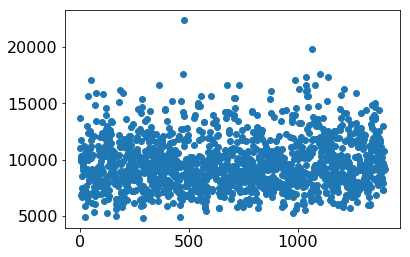

In [52]:
plt.plot(computedrho,'o')

Text(0,0.5,'Probability density')

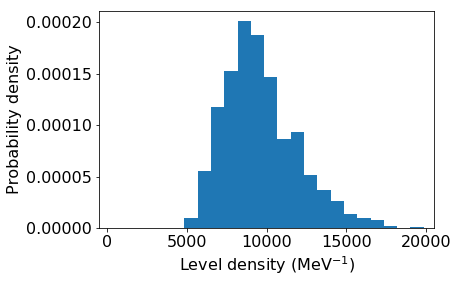

In [61]:
crho=np.array(computedrho)
plt.hist(crho,bins=21,density=True)
plt.xlim(-500,20500)
plt.xlabel(r"Level density (MeV$^{-1}$)")
plt.ylabel(r"Probability density")

In [62]:
print(np.mean(crho), np.sqrt(np.var(crho/np.mean(crho))))

9641.412281977095 0.24039490667941615


In [63]:
print(np.mean(crho)/np.sqrt(np.var(crho)), 0.81/2.37)

4.159821910593021 0.34177215189873417
